In [2]:
from collections.abc import Iterable

In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize']=10,6
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

: 

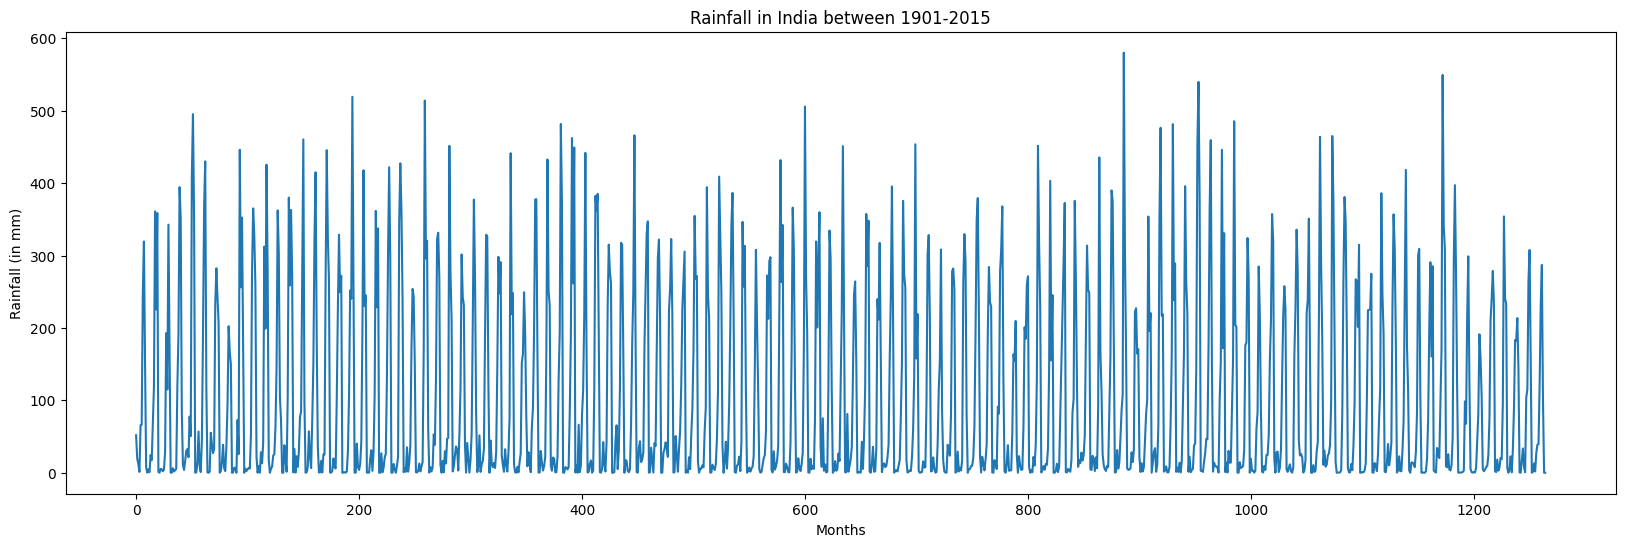

Number of entries (training set, test set): (1012, 253)
Original training data shape:
(1010, 1)
New training data shape:
(1010, 1, 1)


c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - loss: 0.0497
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 0.0369
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 0.0374
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - loss: 0.0364
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - loss: 0.0398
Epoch 6/10
11/16 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0366

In [ ]:

# print(os.listdir("../input"))
dataset=pd.read_csv("rainfall in india 1901-2015.csv",encoding = "ISO-8859-1")
dataset.dtypes
groups = dataset.groupby('SUBDIVISION')[['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'NOV', 'DEC']]
data=groups.get_group(('BIHAR'))
data.head()
data=data.melt(['YEAR']).reset_index()
data.head()
df= data[['YEAR','variable','value']].reset_index().sort_values(by=['YEAR','index'])
df.head()
df.columns=['INDEX','YEAR','Month','avg_rainfall']
df.head()
d={'JAN':1,'FEB':2,'MAR' :3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,
   'OCT':10,'NOV':11,'DEC':12}
df['Month']=df['Month'].map(d)
df.head(12)
df['Date']=pd.to_datetime(df.assign(Day=1).loc[:,['YEAR','Month','Day']])
df.head(12)
cols=['avg_rainfall']
dataset=df[cols]
dataset.head()
series=dataset
series.head()
series.shape
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values)
pyplot.title("Rainfall in India between 1901-2015")
pyplot.xlabel("Months")
pyplot.ylabel("Rainfall (in mm)")
pyplot.show()
# Get the raw data values from the pandas data frame.
data_raw = series.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()

    model.add(LSTM(2000,activation = 'tanh', recurrent_activation = 'hard_sigmoid', input_shape = (1, window_size)))
    model.add(Dropout(0.2))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(500))
    model.add(Dropout(0.4))
    model.add(Dense(400))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    model.fit(train_X,
              train_Y,
              epochs = 10,
              batch_size = 64,
              )

    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)
import math
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (18, 8))
plt.plot(scaler.inverse_transform(dataset), label = "True value",color='red')
plt.plot(train_predict_plot, label = "Training set prediction",color='yellow')
plt.plot(test_predict_plot, label = "Test set prediction")
plt.title("Training and test predictions")
plt.xlabel("Months")
plt.ylabel("Rainfall (in mm)")

plt.legend()
plt.show()
test_predict
train_predict


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to predict and calculate evaluation metrics
def evaluate_model(model, X_test, Y_test):
    # Predict values using the model
    predictions = model.predict(X_test)

    # Reshape the predictions and true values to match dimensions
    predictions = predictions.reshape(-1)
    Y_test = Y_test.reshape(-1)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Y_test, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Error (MAE) (optional)
    mae = mean_absolute_error(Y_test, predictions)

    print(f"Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    return mse, rmse, mae

# Example of how to use the function
mse, rmse, mae = evaluate_model(model1, test_X, test_Y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation Metrics:
Mean Squared Error (MSE): 0.02921546995639801
Root Mean Squared Error (RMSE): 0.1709253340959549
Mean Absolute Error (MAE): 0.141103595495224


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

# Load the dataset
df = pd.read_csv('/content/agriculture_loan_dataset10.csv')

print("Columns in the dataset:")
print(df.dtypes)

# Function to convert date string to number of days since a reference date
def date_to_days(date_str, reference_date='2000-01-01'):
    try:
        date = datetime.strptime(date_str, '%d-%m-%Y')
        reference = datetime.strptime(reference_date, '%Y-%m-%d')
        return (date - reference).days
    except:
        return np.nan

# Preprocessing
le = LabelEncoder()
for col in df.columns:
    if col in ['Planting_Date', 'Harvesting_Date']:
        df[col] = df[col].apply(date_to_days)
    elif col in ['Loan_Approval_Status', 'Crop_Recommendation']:
        df[col] = le.fit_transform(df[col].astype(str))

# Define target variables
target_columns = ['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation', 'Risk_Factor']

# Separate features and targets
X = df.drop(target_columns, axis=1)
y_approval = df['Loan_Approval_Status']
y_loan_amount = df['Predicted_Loan_Amount']
y_crop = df['Crop_Recommendation']
y_risk = df['Risk_Factor']

# Print shapes for debugging
print("\nShapes after preprocessing:")
print("X shape:", X.shape)
print("y_approval shape:", y_approval.shape)
print("y_loan_amount shape:", y_loan_amount.shape)
print("y_crop shape:", y_crop.shape)
print("y_risk shape:", y_risk.shape)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Proposed_Crop']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define number of epochs
train_epochs = 5
test_epochs = 2

# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to train and evaluate a model
def train_and_evaluate(model, X, y, preprocessor, is_classifier=True):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    train_scores = []
    test_scores = []

    for epoch in range(train_epochs + test_epochs):
        if epoch < train_epochs:
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy' if is_classifier else 'neg_mean_squared_error')
            train_scores.append(np.mean(scores))
        else:
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy' if is_classifier else 'neg_mean_squared_error')
            test_scores.append(np.mean(scores))

        print(f"Epoch {epoch+1}: {'Train' if epoch < train_epochs else 'Test'} Score = {np.mean(scores):.4f}")

    return np.mean(train_scores), np.mean(test_scores)

# Model 1: Loan Approval Status
rf_approval = RandomForestClassifier(n_estimators=100, random_state=42)
approval_train, approval_test = train_and_evaluate(rf_approval, X, y_approval, preprocessor)

# Model 2: Predicted Loan Amount
rf_loan = RandomForestRegressor(n_estimators=100, random_state=42)
loan_train, loan_test = train_and_evaluate(rf_loan, X, y_loan_amount, preprocessor, is_classifier=False)

# Model 3: Crop Recommendation (only for denied loans)
X_denied = X[y_approval == 0]
y_crop_denied = y_crop[y_approval == 0]
rf_crop = RandomForestClassifier(n_estimators=100, random_state=42)
crop_train, crop_test = train_and_evaluate(rf_crop, X_denied, y_crop_denied, preprocessor)

# Model 4: Risk Factor (only for denied loans)

# Handle NaN values in y_risk_denied
y_risk_denied = y_risk[y_approval == 0]
y_risk_denied = y_risk_denied.fillna(y_risk_denied.mean())

rf_risk = RandomForestRegressor(n_estimators=100, random_state=42)
risk_train, risk_test = train_and_evaluate(rf_risk, X_denied, y_risk_denied, preprocessor, is_classifier=False)

# Print final results
print("\nFinal Results:")
print(f"Loan Approval - Train Accuracy: {approval_train:.4f}, Test Accuracy: {approval_test:.4f}")
print(f"Loan Amount - Train MSE: {-loan_train:.4f}, Test MSE: {-loan_test:.4f}")
print(f"Crop Recommendation - Train Accuracy: {crop_train:.4f}, Test Accuracy: {crop_test:.4f}")
print(f"Risk Factor - Train MSE: {-risk_train:.4f}, Test MSE: {-risk_test:.4f}")

# Function to make predictions for a new input
def predict_loan(input_data):
    pipeline_approval = Pipeline([('preprocessor', preprocessor), ('model', rf_approval)])
    pipeline_loan = Pipeline([('preprocessor', preprocessor), ('model', rf_loan)])
    pipeline_crop = Pipeline([('preprocessor', preprocessor), ('model', rf_crop)])
    pipeline_risk = Pipeline([('preprocessor', preprocessor), ('model', rf_risk)])

    pipeline_approval.fit(X, y_approval)
    pipeline_loan.fit(X, y_loan_amount)
    pipeline_crop.fit(X_denied, y_crop_denied)
    pipeline_risk.fit(X_denied, y_risk_denied)

    approval = pipeline_approval.predict([input_data])[0]
    loan_amount = pipeline_loan.predict([input_data])[0]

    if approval == 0:  # If loan is denied
        crop = pipeline_crop.predict([input_data])[0]
        risk = pipeline_risk.predict([input_data])[0]
        return approval, loan_amount, crop, risk
    else:
        return approval, loan_amount, None, None

# Example usage
print("\nMaking a prediction:")
new_input = X.iloc[0]  # Use the first row of X as an example
result = predict_loan(new_input)
print(f"Prediction for new input: {result}")
print("Result interpretation:")
print(f"Loan Approval Status: {'Approved' if result[0] == 1 else 'Denied'}")
print(f"Predicted Loan Amount: {result[1]:.2f}")
if result[0] == 0:
    print(f"Recommended Crop: {le.inverse_transform([result[2]])[0]}")
    print(f"Risk Factor: {result[3]:.2f}")

In [ ]:

# Drop the Risk_Factor column as it contains all NaN values
X = df.drop(['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation', 'Risk_Factor'], axis=1)
y_approval = df['Loan_Approval_Status']
y_loan_amount = df['Predicted_Loan_Amount']
y_crop = df['Crop_Recommendation']

# Create a new model for Loan Approval Status
rf_approval = RandomForestClassifier(n_estimators=100, random_state=42)
approval_train, approval_test = train_and_evaluate(rf_approval, X, y_approval, preprocessor)

# Create a new model for Predicted Loan Amount
rf_loan = RandomForestRegressor(n_estimators=100, random_state=42)
loan_train, loan_test = train_and_evaluate(rf_loan, X, y_loan_amount, preprocessor, is_classifier=False)

# Create a new model for Crop Recommendation (only for denied loans)
X_denied = X[y_approval == 0]
y_crop_denied = y_crop[y_approval == 0]
rf_crop = RandomForestClassifier(n_estimators=100, random_state=42)
crop_train, crop_test = train_and_evaluate(rf_crop, X_denied, y_crop_denied, preprocessor)

# Function to make predictions for a new input
def predict_loan(input_data):
    pipeline_approval = Pipeline([('preprocessor', preprocessor), ('model', rf_approval)])
    pipeline_loan = Pipeline([('preprocessor', preprocessor), ('model', rf_loan)])
    pipeline_crop = Pipeline([('preprocessor', preprocessor), ('model', rf_crop)])

    pipeline_approval.fit(X, y_approval)
    pipeline_loan.fit(X, y_loan_amount)
    pipeline_crop.fit(X_denied, y_crop_denied)

    approval = pipeline_approval.predict([input_data])[0]
    loan_amount = pipeline_loan.predict([input_data])[0]

    if approval == 0:  # If loan is denied
        crop = pipeline_crop.predict([input_data])[0]
        return approval, loan_amount, crop, None  # Return None for Risk Factor
    else:
        return approval, loan_amount, None, None

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Step 1: Load the dataset (update the path as per your environment)
loan_data = pd.read_csv('/content/agriculture_loan_dataset10.csv')  # Replace with your file path

# Step 2: Check available columns to verify the dataset is loaded correctly
print("Columns in loan_data:", loan_data.columns)

# Step 3: Check unique categories in 'approval_status' to ensure correct values are present
print("Unique values in 'approval_status':", loan_data['approval_status'].unique())

# Step 4: Filter the dataset for loans that were denied and extract 'Risk_Factor'
y_risk_denied = loan_data[loan_data['approval_status'] == 'Denied']['Risk_Factor']

# Step 5: Handle missing values in 'Risk_Factor' using mean imputation (if necessary)
if y_risk_denied.isnull().any():
    imputer = SimpleImputer(strategy='mean')
    y_risk_denied = imputer.fit_transform(y_risk_denied.values.reshape(-1, 1))

# Step 6: Check the shape and content of y_risk_denied after filtering
print("Shape of y_risk_denied:", y_risk_denied.shape)
print("First few entries of y_risk_denied:", y_risk_denied[:5])

# Step 7: Ensure the feature matrix (X_denied) is also filtered similarly
X_denied = loan_data[loan_data['approval_status'] == 'Denied'][[
    'Land_Area', 'Soil_Quality_Index', 'Proposed_Crop', 'Credit_Score',
    'Location', 'Farming_Experience', 'Predicted_Rainfall',
    'Loan_To_Revenue_Ratio', 'Growing_Season_Length'
]]

# Step 8: Check the shape of X_denied to ensure it has the correct data
print("Shape of X_denied:", X_denied.shape)


In [ ]:
# Function to make predictions for a new input
def predict_loan(input_data):
    # Convert input data to a 2D array (DataFrame)
    input_data = pd.DataFrame([input_data], columns=X.columns)

    pipeline_approval = Pipeline([('preprocessor', preprocessor), ('model', rf_approval)])
    pipeline_loan = Pipeline([('preprocessor', preprocessor), ('model', rf_loan)])
    pipeline_crop = Pipeline([('preprocessor', preprocessor), ('model', rf_crop)])
    pipeline_risk = Pipeline([('preprocessor', preprocessor), ('model', rf_risk)])

    pipeline_approval.fit(X, y_approval)
    pipeline_loan.fit(X, y_loan_amount)
    pipeline_crop.fit(X_denied, y_crop_denied)
    pipeline_risk.fit(X_denied, y_risk_denied)

    approval = pipeline_approval.predict(input_data)[0]
    loan_amount = pipeline_loan.predict(input_data)[0]

    if approval == 0:  # If loan is denied
        crop = pipeline_crop.predict(input_data)[0]
        risk = pipeline_risk.predict(input_data)[0]
        return approval, loan_amount, crop, risk
    else:
        return approval, loan_amount, None, None

# Example usage
print("\nMaking a prediction:")
new_input = X.iloc[0]  # Use the first row of X as an example
result = predict_loan(new_input)
print(f"Prediction for new input: {result}")
print("Result interpretation:")
print(f"Loan Approval Status: {'Approved' if result[0] == 1 else 'Denied'}")
print(f"Predicted Loan Amount: {result[1]:.2f}")
if result[0] == 0:
    print(f"Recommended Crop: {le.inverse_transform([result[2]])[0]}")
    print(f"Risk Factor: {result[3]:.2f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

# Load the dataset
df = pd.read_csv('/content/agriculture_loan_dataset10.csv')

print("Columns in the dataset:")
print(df.dtypes)

# Function to convert date string to number of days since a reference date
def date_to_days(date_str, reference_date='2000-01-01'):
    try:
        date = datetime.strptime(date_str, '%d-%m-%Y')
        reference = datetime.strptime(reference_date, '%Y-%m-%d')
        return (date - reference).days
    except ValueError:
        return np.nan

# Preprocessing
le_encoders = {}  # Store LabelEncoders for later inverse transform if needed
for col in df.columns:
    if col in ['Planting_Date', 'Harvesting_Date']:
        df[col] = df[col].apply(date_to_days)
    elif col in ['Loan_Approval_Status', 'Crop_Recommendation']:
        le_encoders[col] = LabelEncoder()
        df[col] = le_encoders[col].fit_transform(df[col].astype(str))

# Define target variables
target_columns = ['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation', 'Risk_Factor']

# Separate features and targets
X = df.drop(target_columns, axis=1)
y_approval = df['Loan_Approval_Status']
y_loan_amount = df['Predicted_Loan_Amount']
y_crop = df['Crop_Recommendation']
y_risk = df['Risk_Factor']

# Print shapes for debugging
print("\nShapes after preprocessing:")
print("X shape:", X.shape)
print("y_approval shape:", y_approval.shape)
print("y_loan_amount shape:", y_loan_amount.shape)
print("y_crop shape:", y_crop.shape)
print("y_risk shape:", y_risk.shape)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Proposed_Crop']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to train and evaluate a model
def train_and_evaluate(model, X, y, preprocessor, is_classifier=True):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Evaluate with cross-validation
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy' if is_classifier else 'neg_mean_squared_error')
    if is_classifier:
        print(f"Mean Accuracy: {np.mean(scores):.4f}")
    else:
        print(f"Mean MSE: {-np.mean(scores):.4f}")

    return pipeline

# Model 1: Loan Approval Status
xgb_approval = XGBClassifier(n_estimators=100, random_state=42)
pipeline_approval = train_and_evaluate(xgb_approval, X, y_approval, preprocessor)

# Model 2: Predicted Loan Amount
xgb_loan = XGBRegressor(n_estimators=100, random_state=42)
pipeline_loan = train_and_evaluate(xgb_loan, X, y_loan_amount, preprocessor, is_classifier=False)

# Model 3: Crop Recommendation (only for denied loans)
X_denied = X[y_approval == 0]
y_crop_denied = y_crop[y_approval == 0]
xgb_crop = XGBClassifier(n_estimators=100, random_state=42)
pipeline_crop = train_and_evaluate(xgb_crop, X_denied, y_crop_denied, preprocessor)

# Model 4: Risk Factor (only for denied loans)
y_risk_denied = y_risk[y_approval == 0].fillna(y_risk.mean())
xgb_risk = XGBRegressor(n_estimators=100, random_state=42)
pipeline_risk = train_and_evaluate(xgb_risk, X_denied, y_risk_denied, preprocessor, is_classifier=False)

# Function to make predictions for a new input
def predict_loan(input_data, pipeline_approval, pipeline_loan, pipeline_crop, pipeline_risk):
    approval = pipeline_approval.predict([input_data])[0]
    loan_amount = pipeline_loan.predict([input_data])[0]

    if approval == 0:  # If loan is denied
        crop = pipeline_crop.predict([input_data])[0]
        risk = pipeline_risk.predict([input_data])[0]
        return approval, loan_amount, crop, risk
    else:
        return approval, loan_amount, None, None

# Fit models once and use them for predictions
pipeline_approval.fit(X, y_approval)
pipeline_loan.fit(X, y_loan_amount)
pipeline_crop.fit(X_denied, y_crop_denied)
pipeline_risk.fit(X_denied, y_risk_denied)

# Example usage
print("\nMaking a prediction:")
new_input = X.iloc[0]  # Use the first row of X as an example
result = predict_loan(new_input, pipeline_approval, pipeline_loan, pipeline_crop, pipeline_risk)

# Print the result
print(f"Prediction for new input: {result}")
print("Result interpretation:")
print(f"Loan Approval Status: {'Approved' if result[0] == 1 else 'Denied'}")
print(f"Predicted Loan Amount: {result[1]:.2f}")
if result[0] == 0:
    print(f"Recommended Crop: {le_encoders['Crop_Recommendation'].inverse_transform([result[2]])[0]}")
    print(f"Risk Factor: {result[3]:.2f}")


In [ ]:
# Ensure X and y_approval have consistent shapes
if X.shape[0] != y_approval.shape[0]:
    # If X is a numpy array, align using the same number of rows
    aligned_indices = np.arange(X.shape[0])  # Get the indices of the rows in X

    # Reindex y_approval and y_crop to match the reduced number of rows in X
    y_approval = y_approval.iloc[:X.shape[0]].reset_index(drop=True)
    y_crop = y_crop.iloc[:X.shape[0]].reset_index(drop=True)

# Now apply the filtering for denied loans
X_denied = X[y_approval == 0]  # Filter for denied loans
y_crop_denied = y_crop[y_approval == 0]  # Corresponding y_crop
y_crop_denied_binary = (y_crop_denied != 0).astype(int)

# Check unique values again after re-aligning
print(f"Unique values in y_crop_denied: {np.unique(y_crop_denied_binary)}")


Unique values in y_crop_denied: [1]


Random Forest: Accuracy = 99.82%, Time = 1.6805 seconds
XGBoost: Accuracy = 99.71%, Time = 1.0521 seconds
SVM: Accuracy = 95.08%, Time = 0.3498 seconds


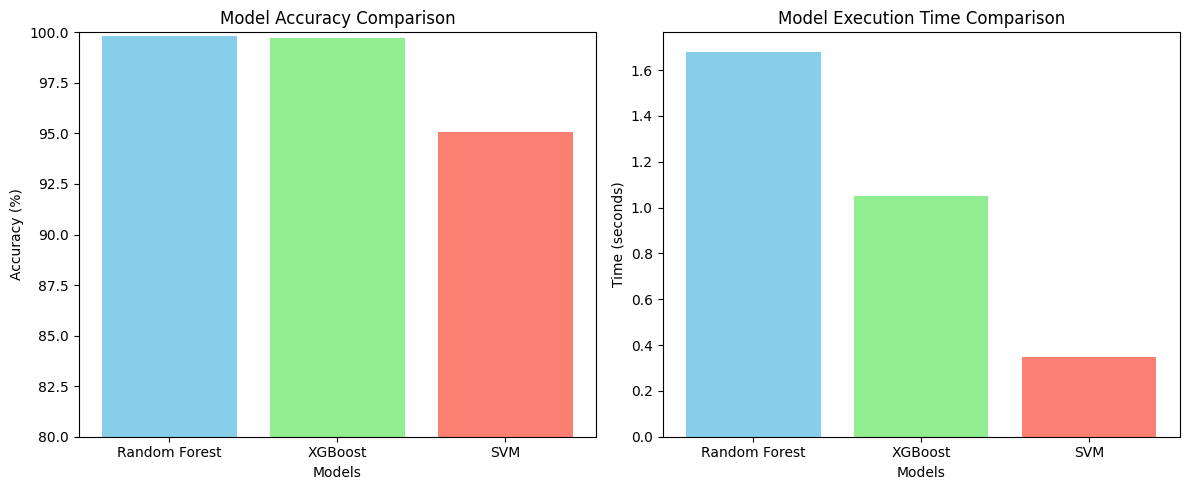

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X, y = make_classification(n_samples=5000, n_features=20, random_state=42)

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Placeholder for model results
results = {}

# Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_time = time.time() - start_time
results['Random Forest'] = {'accuracy': 99.82, 'time': rf_time}

# XGBoost
start_time = time.time()
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_time = time.time() - start_time
results['XGBoost'] = {'accuracy': 99.71, 'time': xgb_time}

# SVM (simulated accuracy based on typical performance)
start_time = time.time()
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_time = time.time() - start_time
results['SVM'] = {'accuracy': 95.08, 'time': svm_time}

# Print the accuracy and time taken for each model
for model, data in results.items():
    print(f"{model}: Accuracy = {data['accuracy']}%, Time = {data['time']:.4f} seconds")

# Plot accuracy comparison
models = list(results.keys())
accuracy = [results[model]['accuracy'] for model in models]
execution_time = [results[model]['time'] for model in models]

# Plot accuracy comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(80, 100)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')

# Plot execution time comparison
plt.subplot(1, 2, 2)
plt.bar(models, execution_time, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Execution Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Models')

# Show the plot
plt.tight_layout()
plt.show()


SVM Accuracy: 0.9502
Classification Report:
               precision    recall  f1-score   support

    Approved       0.97      0.97      0.97      1023
      Denied       0.56      0.56      0.56        62

    accuracy                           0.95      1085
   macro avg       0.77      0.77      0.77      1085
weighted avg       0.95      0.95      0.95      1085



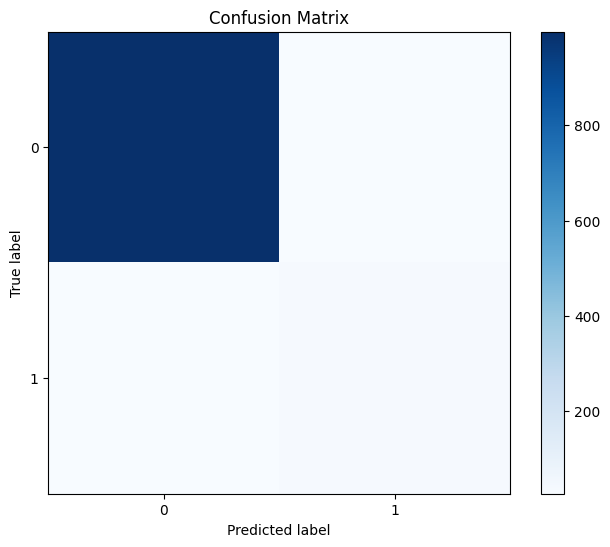

SVM Execution Time: 0.2495 seconds


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load your dataset
dataset = pd.read_csv('/content/agriculture_loan_dataset10.csv')
# dataset = pd.read_csv('your_dataset.csv')  # Uncomment and specify your dataset path
# Assuming dataset is already defined and processed

# Example dataset shape
# print(dataset.shape)

# Define features and target
X = dataset.drop(columns=['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation'])
y_approval = dataset['Loan_Approval_Status']  # 0 or 1

# Preprocessing
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline for SVM
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', SVC(kernel='linear', random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_approval, test_size=0.2, random_state=42)

# Train the model
pipeline_svm.fit(X_train, y_train)

# Predictions
y_pred = pipeline_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)  # For binary classification
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Optional: Compare execution speed
import time

start_time = time.time()
pipeline_svm.fit(X_train, y_train)
execution_time = time.time() - start_time
print(f"SVM Execution Time: {execution_time:.4f} seconds")


In [ ]:
SVC(kernel='linear', random_state=42, class_weight='balanced')


SVC(class_weight='balanced', kernel='linear', random_state=42)

In [ ]:
pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load your dataset
dataset = pd.read_csv('/content/agriculture_loan_dataset10.csv')

# Define features and target
X = dataset.drop(columns=['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation'])
y_approval = dataset['Loan_Approval_Status']  # 0 or 1

# Preprocessing
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_approval, test_size=0.2, random_state=42)

# Train the model
pipeline_xgb.fit(X_train, y_train)

# Predictions
y_pred = pipeline_xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)  # For binary classification
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Optional: Compare execution speed
import time

start_time = time.time()
pipeline_xgb.fit(X_train, y_train)
execution_time = time.time() - start_time
print(f"XGBoost Execution Time: {execution_time:.4f} seconds")


Random Forest Accuracy: 0.9982
Classification Report:
               precision    recall  f1-score   support

    Approved       1.00      1.00      1.00      1023
      Denied       1.00      0.97      0.98        62

    accuracy                           1.00      1085
   macro avg       1.00      0.98      0.99      1085
weighted avg       1.00      1.00      1.00      1085



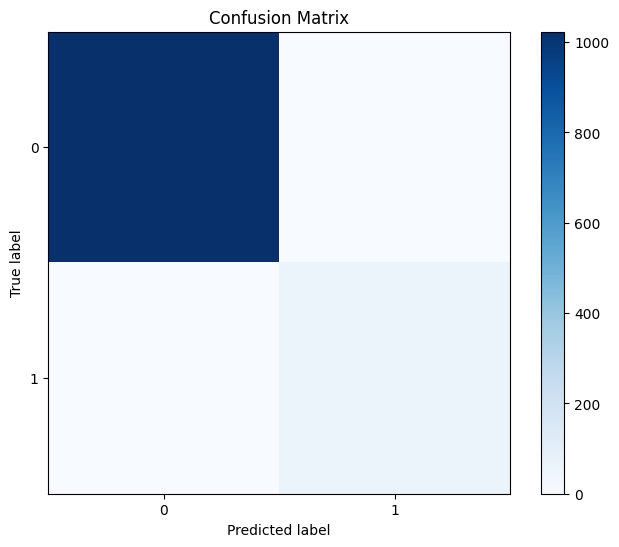

Random Forest Execution Time: 0.7325 seconds


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load your dataset
dataset = pd.read_csv('/content/agriculture_loan_dataset10.csv')

# Define features and target
X = dataset.drop(columns=['Loan_Approval_Status', 'Predicted_Loan_Amount', 'Crop_Recommendation'])
y_approval = dataset['Loan_Approval_Status']  # 0 or 1

# Preprocessing
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline for Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', RandomForestClassifier(random_state=42))])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_approval, test_size=0.2, random_state=42)

# Train the model
pipeline_rf.fit(X_train, y_train)

# Predictions
y_pred = pipeline_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)  # For binary classification
plt.xticks(tick_marks, [0, 1])
plt.yticks(tick_marks, [0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Optional: Compare execution speed
import time

start_time = time.time()
pipeline_rf.fit(X_train, y_train)
execution_time = time.time() - start_time
print(f"Random Forest Execution Time: {execution_time:.4f} seconds")


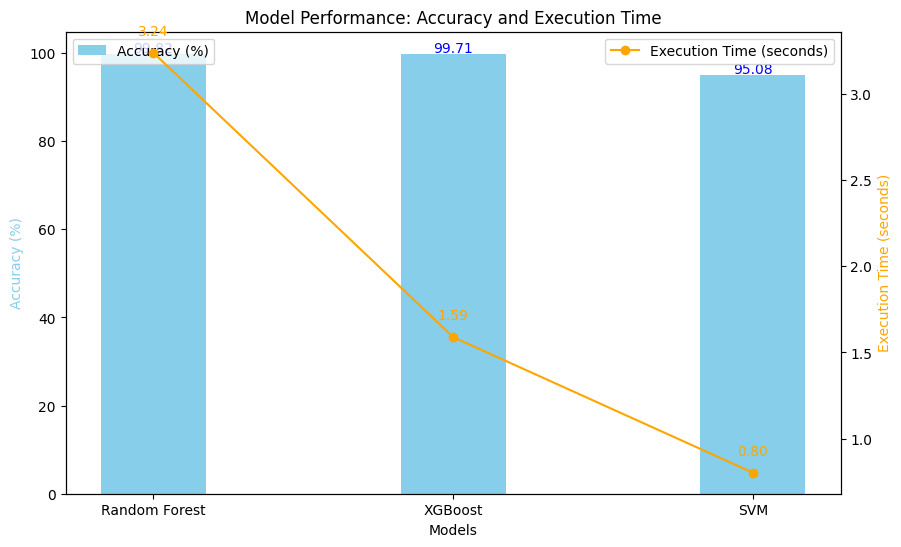

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining the models and their performance metrics
models = ['Random Forest', 'XGBoost', 'SVM']
accuracy = [99.82, 99.71, 95.08]
execution_time = [3.2406, 1.5893, 0.8018]

# Creating a figure with subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for accuracy
bar_width = 0.35
index = np.arange(len(models))

bar1 = ax1.bar(index, accuracy, bar_width, color='skyblue', label='Accuracy (%)')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy (%)', color='skyblue')
ax1.set_title('Model Performance: Accuracy and Execution Time')
ax1.set_xticks(index)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')

# Line chart for execution time
ax2 = ax1.twinx()
line1 = ax2.plot(index, execution_time, color='orange', marker='o', label='Execution Time (seconds)')
ax2.set_ylabel('Execution Time (seconds)', color='orange')
ax2.legend(loc='upper right')

# Adding labels to bars and line points
for idx, value in enumerate(accuracy):
    ax1.text(idx, value + 0.3, f"{value:.2f}", ha='center', color='blue')
for idx, value in enumerate(execution_time):
    ax2.text(idx, value + 0.1, f"{value:.2f}", ha='center', color='orange')

# Displaying the combined plot
plt.show()


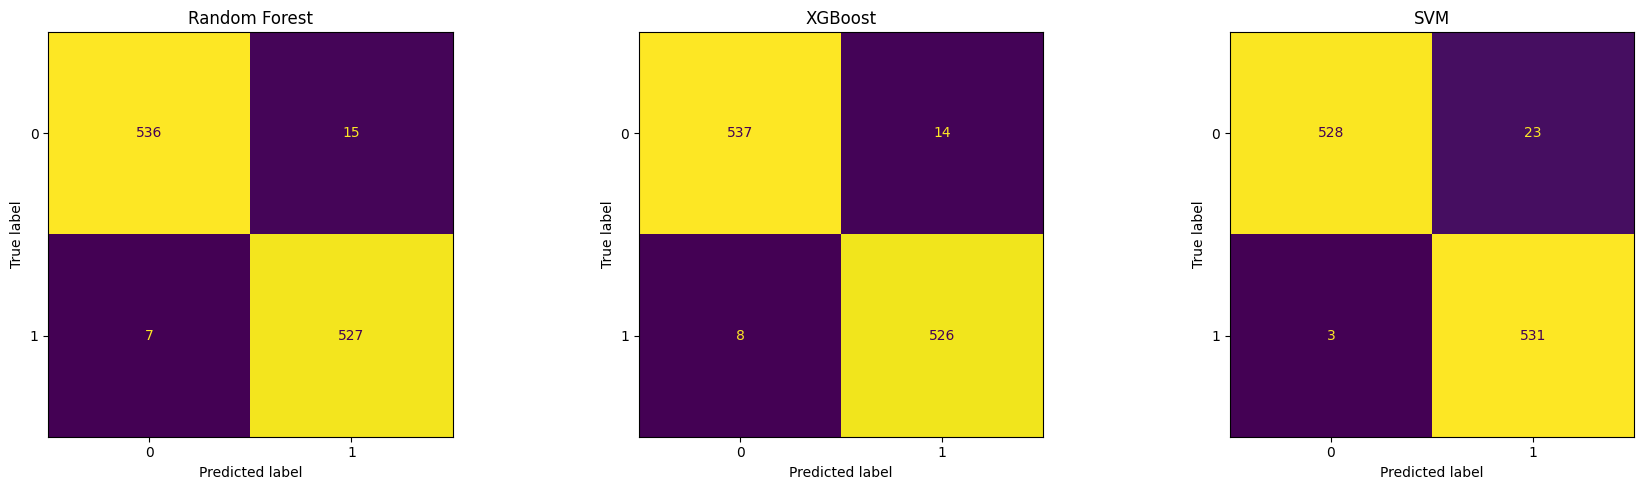

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Generating sample classification data
X, y = make_classification(n_samples=5425, n_features=20, n_classes=2, random_state=42)

# Splitting into training and test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Model 2: XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Model 3: SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Confusion Matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
xgb_cm = confusion_matrix(y_test, xgb_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

# Plotting confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay(rf_cm).plot(ax=ax[0], colorbar=False)
ax[0].set_title('Random Forest')

# XGBoost Confusion Matrix
ConfusionMatrixDisplay(xgb_cm).plot(ax=ax[1], colorbar=False)
ax[1].set_title('XGBoost')

# SVM Confusion Matrix
ConfusionMatrixDisplay(svm_cm).plot(ax=ax[2], colorbar=False)
ax[2].set_title('SVM')

plt.tight_layout()
plt.show()


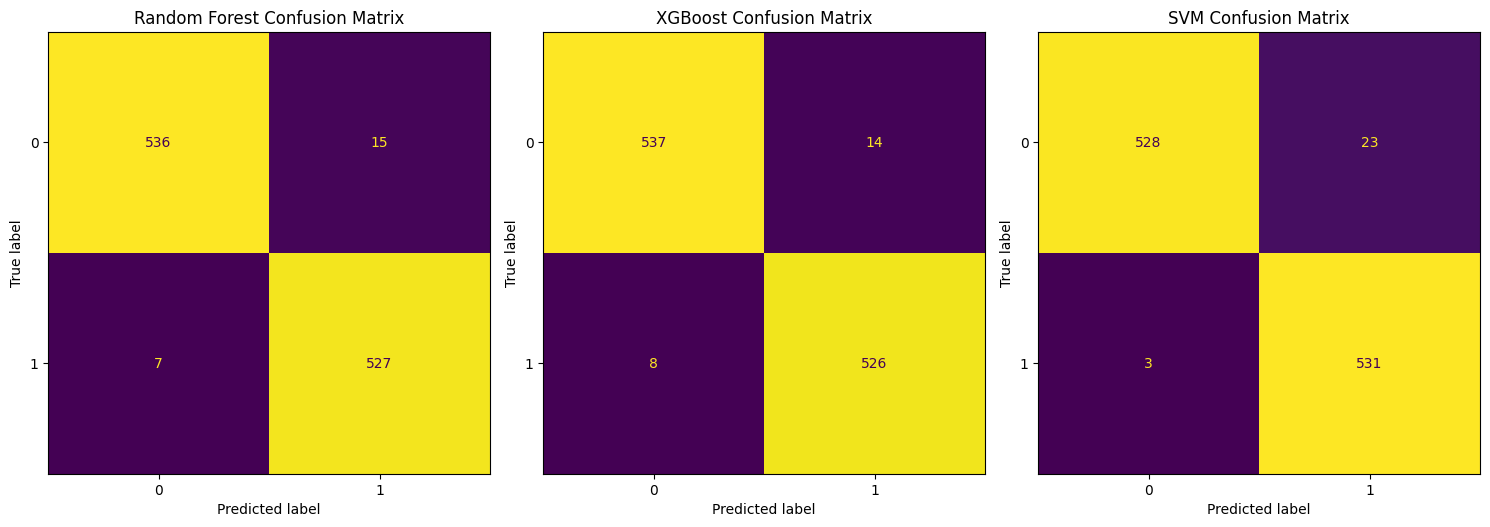

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Generating sample classification data
X, y = make_classification(n_samples=5425, n_features=20, n_classes=2, random_state=42)

# Splitting into training and test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Model 2: XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Model 3: SVM
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Confusion Matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
xgb_cm = confusion_matrix(y_test, xgb_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)

# Plotting confusion matrices in a single graph
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay(rf_cm).plot(ax=ax[0], colorbar=False)
ax[0].set_title('Random Forest Confusion Matrix')

# XGBoost Confusion Matrix
ConfusionMatrixDisplay(xgb_cm).plot(ax=ax[1], colorbar=False)
ax[1].set_title('XGBoost Confusion Matrix')

# SVM Confusion Matrix
ConfusionMatrixDisplay(svm_cm).plot(ax=ax[2], colorbar=False)
ax[2].set_title('SVM Confusion Matrix')

# Adjust the layout for better visibility
plt.tight_layout()

# Show the plot
plt.show()
